In [2]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

# Load Data

In [3]:
test = pd.read_csv('/Users/wangxueying/PycharmProjects/Python/Translation_Test/test_table.csv', parse_dates = ['date'])
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [5]:
user = pd.read_csv('/Users/wangxueying/PycharmProjects/Python/Translation_Test/user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [7]:
# check if user_id is unique
# counts of user_id in test and user table are different, let's check it
print('Counts of unique ID in Test:\t', len(test.user_id.unique()), '\tAre IDs Unique?:', len(test.user_id.unique()) == len(test))
print('Counts of unique ID in User:\t', len(user.user_id.unique()), '\tAre IDs Unique?:', len(user.user_id.unique()) == len(user))

Counts of unique ID in Test:	 453321 	Are IDs Unique?: True
Counts of unique ID in User:	 452867 	Are IDs Unique?: True


It seems we miss some User ID in the User dataset. Special attention while joining the table.

In [8]:
# Merge two tables. Since more IDs in test table, put it at left
df = pd.merge(left = test, right = user, how = 'left', on = 'user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


In [9]:
#check if it is true Spain converts much better than the rest of LatAm countries.
conversiton_rate_country = df[df.test == 0][['country','conversion']].groupby('country').mean().reset_index()
conversiton_rate_country = conversiton_rate_country.sort_values(by = 'conversion', ascending = False)
print(conversiton_rate_country)

        country  conversion
14        Spain    0.079719
6   El Salvador    0.053554
10    Nicaragua    0.052647
4    Costa Rica    0.052256
3      Colombia    0.052089
8      Honduras    0.050906
7     Guatemala    0.050643
16    Venezuela    0.050344
13         Peru    0.049914
9        Mexico    0.049495
1       Bolivia    0.049369
5       Ecuador    0.049154
12     Paraguay    0.048493
2         Chile    0.048107
11       Panama    0.046796
0     Argentina    0.015071
15      Uruguay    0.012048


In [10]:
from scipy import stats
#since nothing changed in spain, I will remove these region group
df_nospain = df[df['country'] != 'Spain']

test_group = df_nospain[df_nospain['test'] == 1]['conversion']
control_group =  df_nospain[df_nospain['test'] == 0]['conversion']

print('mean of conversion rate for control:', round(control_group.mean(),5), 'mean of conversion rate for test:',round(test_group.mean(),5))

print(stats.ttest_ind(test_group, control_group, equal_var = False))

mean of conversion rate for control: 0.04833 mean of conversion rate for test: 0.04342
Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


control group has a large drop on conversion rate
This experiment seems has some problems:
- not enough data
- two groups of people are not randomly selected

In [11]:
df_test = df[df.test == 1][['conversion','date']].groupby('date').mean().reset_index()
df_control = df[df.test == 0][['conversion','date']].groupby('date').mean().reset_index()
#df_ratio['conversion'].transform(lambda x: x /(df_control['conversion']))
df_compare = df_test.merge(df_control, how = 'inner', on = 'date', suffixes=('_test', '_control'))
df_compare['ratio'] = df_compare[['conversion_test']].div(df_compare['conversion_control'].values, axis = 0)
print(df_compare)

        date  conversion_test  conversion_control     ratio
0 2015-11-30         0.043886            0.057374  0.764911
1 2015-12-01         0.041387            0.053616  0.771928
2 2015-12-02         0.044234            0.055364  0.798965
3 2015-12-03         0.043884            0.056094  0.782333
4 2015-12-04         0.043491            0.054122  0.803564


Text(0.5, 1.0, 'Test over control for conversion rate')

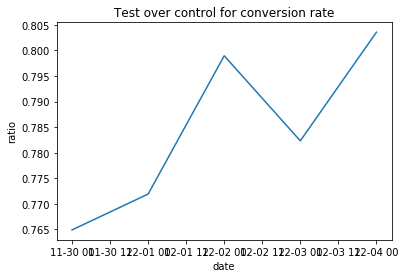

In [11]:
# check the comparision of rate by test/control each day
fig = plt.figure()
ax1 = fig.add_subplot(figsize = (2,20))
ax1 = sns.lineplot(x = 'date', y = 'ratio', data = df_compare, dashes = True)
ax1.set_title('Test over control for conversion rate')

- The conversion rate of control is higher than test group. There must be some bias included
- the experient only ran for 5 days. It needs to be ran longer.

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
#from sklearn.preprocessing import LabelEncoder

train_x = df_nospain[['test','country']]

# Change data to category
for col in train_x.select_dtypes(include=['object']).columns:
    train_x[col] = train_x[col].astype('category')
    
# Encoding categorical features
for col in train_x.select_dtypes(include=['category']).columns:
    train_x[col] = train_x[col].cat.codes

train_y = df_nospain['conversion'].values

# Build decision tree
clf = DecisionTreeClassifier(max_depth = 2)
clf = clf.fit(X = train_x, y = train_y)

In [14]:
print(train_x.head(), train_y)

   test  country
1     1        9
3     1        9
4     1        9
5     1       15
6     0        9 [0 0 0 ... 0 0 0]


In [ ]:
!pip install graphviz

In [ ]:
# Visualization
from graphviz import Source 
from sklearn.tree import export_graphviz
from IPython.display import SVG
from IPython.display import display

#Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))
graph = Source(tree.export_graphviz(clf, out_file=None, filled=True, 
                                    feature_names = train_x.columns, class_names=['0', '1'], 
                                    rounded=True, special_characters=True))
display(SVG(graph.pipe(format='svg')))

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())





In [ ]:
countries = [i for i in df_nospain.country.unique() if i is not np.nan]
print('{0:15s} {1:>15s} {2:>16s} {3:15s}'.format('Country','P-Value','Rate_test', 'Rate_Control'))
print('-'*60)
for country in countries:
    
    control_col = df_nospain[(df_nospain['country'] == country) & (df_nospain['test'] == 0)]['conversion'].values
    test_col = df_nospain[(df_nospain['country'] == country) & (df_nospain['test'] == 1)]['conversion'].values
    
    test_mean = test_col.mean()
    control_mean = control_col.mean()
    
    p_value = ttest_ind(test_col, control_col, equal_var = False).pvalue
    
    print('{0:15s} {1:15f} {2:15.5f} {3:10.5f}'.format(country, p_value, test_mean, control_mean))

Since all p value > 0.05, the results are not significant and don't allow us to reject the null hypothesis.